# Задание №2 

## Сгенерируйте датасет со случайными нормально распределенными величинами $x_1$ и $x_2$ , $corr(x_1, x_2)=-0.7$, размер выборки $N = 1000$ 

## $ y = \beta_0 + \beta_1x_1 + \beta_2x_2 + \epsilon$

In [111]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from scipy import stats
import scipy as sci

## Необходимые функции

In [112]:
def gen_normal(mean, std, size, seed):

    # К сожалению, самый просто способ избавиться от случайности -
    # вызывать один и тот же random seed каждый раз перед запуском функции
    np.random.seed(seed)

    # Генерируем выборку
    x = np.random.normal(loc=mean, scale=std, size=size)

    return(x)

def gen_uniform(mean, width, size, seed):

    # К сожалению, самый просто способ избавиться от случайности -
    # вызывать один и тот же random seed каждый раз перед запуском функции
    np.random.seed(seed)

    # Генерируем выборку
    x = np.random.uniform(low=mean - width/2, high=mean + width/2, size=size)

    return(x)

def gen_data(y_type, params, seed):

    # К сожалению, самый просто способ избавиться от случайности -
    # вызывать один и тот же random seed каждый раз перед запуском функции
    np.random.seed(seed)

    # Генерация датасета для задачи пропущенной переменной и мультиколлинеарности
    if y_type == 'multivariate':

        # Сгенерируем значения факторов и форму зависимости y от регрессоров
        means = [params['x1_mean'], params['x2_mean']]

        # Вычислим наполнение матрицы ковариаций 
        var_1 = params['x1_std']**2
        var_2 = params['x2_std']**2


        cov_12 = params['corr_12'] * params['x1_std'] * params['x2_std']

        
        # Сгененрируем требующуюся выборку
        X = np.random.multivariate_normal(
            mean=means,
            cov=[[var_1, cov_12],
                 [cov_12, var_2]],
            size=params['N']
        )

        # А также сгененируем случайную ошибку как величину из нормального распределения
        e = np.random.normal(loc=params['e_mean'], scale=params['e_std'], size=params['N'])

        # Здесь мы создаем таргет 'y' как некую функцию от x1, x2 и ошибки e
        y = params['beta0'] \
            + params['beta1'] * X[:, 0] \
            + params['beta2'] * X[:, 1] \
            + e

        # Для удобства сохраним вектора в pandas dataframe
        dataset = pd.DataFrame({'x1': X[:, 0], 'x2': X[:, 1], 'e': e, 'y': y})

    return(dataset)

def plot_data(dataset, target, feature_names, plot_type = None, pairwise=False, model=None):

    dataset = dataset.copy()
    # Графики с результатами моделирования
    if plot_type == 'model':

        if pairwise == True:
            
            feat = feature_names[0]
            # Давайте посмотрим, как соотносится реальная выборка с предсказанными значениями
            sns.scatterplot(data=dataset, x=feat, y=target);
            sns.lineplot(x=dataset[feat], y=dataset[f'{target}_hat'], c = 'r');
            plt.xlabel(f'{feat} values')
            plt.ylabel(f'{target} values')
            plt.title(f'{target} vs {feat} distribution and model fit')
            plt.show()

        else:

            # Чтобы сделать функцию гибкой, пройдемся по фичам из списка
            for feat in feature_names:
                
                
                '''
                Предскажем значение таргета при фиксированных средних
                значениях всех перменных, кроме рассматриваемой. И отрисуем
                зависимость между этим фактором и предсказанным таргетом
                '''
                dataset_paired = pd.DataFrame(
                    data = [dataset[feature_names].mean()],
                    index = dataset.index
                    )
                dataset_paired[feat] = dataset[feat]
                dataset_paired['const'] = 1.0
                dataset_paired = dataset_paired[['const'] + feature_names]
                target_paired = model.predict(dataset_paired)

                # Давайте посмотрим, как соотносится реальная выборка с предсказанными значениями
                sns.scatterplot(data=dataset, x=feat, y=target);
                sns.lineplot(x=dataset[feat], y=target_paired, c = 'r');
                plt.xlabel(f'{feat} values')
                plt.ylabel(f'{target} values')
                plt.title(f'{target} vs {feat} distribution and model fit')
                plt.show()

        # Отрисует предсказанные и реальные значения таргета
        sns.scatterplot(data=dataset, x=f'{target}_hat', y=target);
        sns.lineplot(data=dataset, x=target, y=target, c='black', linestyle='--');
        plt.xlabel('Predicted value')
        plt.ylabel('Actual value')
        plt.title('Model fit vs actual data')
        plt.show()

        # А также посмотрим на распределение остатков модели
        sns.displot(dataset['residuals'], bins=20, kde=True);
        plt.xlabel('Model residuals')
        plt.ylabel('Residuals frequency')
        plt.title('Model residuals histogram')
        plt.show()

    # Графики с базовыми распределениями факторов
    elif plot_type == 'EDA':
        
        # Чтобы сделать функцию гибкой, пройдемся по фичам из списка
        for feat in feature_names:

            # Отрисуем распределения нужных нам факторов
            sns.displot(dataset[feat], bins=20, kde=True);
            plt.xlabel(f'{feat} values')
            plt.ylabel(f'{feat} freq')
            plt.title(f'{feat} histogram and density plot')
            plt.show()

            # Также отрисуем зависимость между таргетом и интересующими факторами
            sns.scatterplot(data=dataset, x=feat, y='y');
            plt.xlabel(f'{feat} values')
            plt.ylabel('y values')
            plt.title(f'y vs {feat} distribution')
            plt.show()

def train_model(dataset, target, feature_names, show_results=False, pairwise=False, return_norm_tests=False):

    dataset = dataset.copy()

    # Создадим матрицу фичей как фактор x1 и единичный вектор, на который будет фиттиться константа
    X = sm.add_constant(dataset[feature_names])
    
    # Зафитим модель на данные. y - наша целевая переменная, X - матрица факторов
    model = sm.OLS(dataset[target], X).fit()
    
    dataset[f'{target}_hat'] = model.fittedvalues
    dataset['residuals'] = model.resid
    
    if show_results:
        # Выведем результат построения регрессии
        print(model.summary())
        
        # Выведем графики с результатами модели
        plot_data(dataset, target, feature_names, plot_type='model', pairwise=pairwise, model=model)
        
    # Выведем саммари по тестам
    if return_norm_tests:
        display(norm_distr_check(
            (dataset['residuals'] - np.mean(dataset['residuals']))\
                /np.std(dataset['residuals'])
            ))
    
    return(dataset, model)

def norm_distr_check (
        data,
        p_level:    float = 0.95):

    """
    Проверка нормальности распределения: возвращает DataFrame, содержащий 
    результаты проверки нормальности распределения с использованием различных
    тестов.
    

    Args:
        data:                                     
            исходный массив данных.
            
        p_level (float, optional):           
            доверительная вероятность. 
            Defaults to 0.95.

    Returns:
        result (pd.core.frame.DataFrame):
            результат 
    
    Notes:
        1. Функция реализует следующие тесты:
            - тест Шапиро-Уилка (Shapiro-Wilk test) (при 8 <= N <= 1000)
            - тест Эппса-Палли (Epps_Pulley_test) (при N >= 8)
            - тест Д'Агостино (K2-test)
            - тест Андерсона-Дарлинга (Anderson-Darling test)
            - тест Колмогорова-Смирнова (Kolmogorov-Smirnov test) (при N >= 50)
            - тест Лиллиефорса (Lilliefors’ test)
            - тест Крамера-Мизеса-Смирнова (Cramér-von Mises test) (при N >= 40)
            - тест Пирсона (хи-квадрат) (chi-square test) (при N >= 100)
            - тест Харке-Бера (Jarque-Bera tes) (при N >= 2000)
            - тест асимметрии (при N >= 8)
            - тест эксцесса (при N >= 20)            
            
        2. Функция требует наличия файла table\Epps_Pulley_test_table.csv, 
            который содержит табличные значения критерия Эппса-Палли.
            
    """    
    
    a_level = 1 - p_level
    X = np.array(data)
    N = len(X)
       
    # тест Шапиро-Уилка (Shapiro-Wilk test)
    # https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.shapiro.html
    if N >= 8:
        result_ShW = sci.stats.shapiro(X)
        s_calc_ShW = result_ShW.statistic
        a_calc_ShW = result_ShW.pvalue
        conclusion_ShW = 'gaussian distribution' if a_calc_ShW >= a_level \
            else 'not gaussian distribution'
    else:
        result_ShW = '-'
        s_calc_ShW = '-'
        a_calc_ShW = '-'
        conclusion_ShW = 'count less than 8'

    # тест Эппса-Палли (Epps_Pulley_test)
    сdf_beta_I = lambda x, a, b: sci.stats.beta.cdf(x, a, b, loc=0, scale=1)
    g_beta_III = lambda z, δ: δ*z / (1+(δ-1)*z)
    cdf_beta_III = \
        lambda x, θ0, θ1, θ2, θ3, θ4: \
            сdf_beta_I(g_beta_III((x - θ4)/θ3, θ2), θ0, θ1)
    
    θ_1 = (1.8645, 2.5155, 5.8256, 0.9216, 0.0008)    # для 15 < n < 50
    θ_2 = (1.7669, 2.1668, 6.7594, 0.91, 0.0016)    # для n >= 50
    
    if N >= 8 and N <= 1000:
        X_mean = X.mean()
        m2 = np.var(X, ddof = 0)
        # расчетное значение статистики критерия
        A = np.sqrt(2) * np.sum([np.exp(-(X[i] - X_mean)**2 / (4*m2)) 
                              for i in range(N)])
        B = 2/N * np.sum(
            [np.sum([np.exp(-(X[j] - X[k])**2 / (2*m2)) for j in range(0, k)]) 
             for k in range(1, N)])
        s_calc_EP = 1 + N / np.sqrt(3) + B - A
        # табличное значение статистики критерия
        Tep_table_df = pd.read_csv(
            filepath_or_buffer='table/Epps_Pulley_test_table.csv',
            sep=';',
            index_col='n')
        p_level_dict = {
            0.9:   Tep_table_df.columns[0],
            0.95:  Tep_table_df.columns[1],
            0.975: Tep_table_df.columns[2],
            0.99:  Tep_table_df.columns[3]}
        f_lin = sci.interpolate.interp1d(Tep_table_df.index, \
                                         Tep_table_df[p_level_dict[p_level]])
        critical_value_EP = float(f_lin(N))
        # проверка гипотезы
        if 15 < N < 50:
            a_calc_EP = 1 - cdf_beta_III(s_calc_EP, θ_1[0], θ_1[1], \
                                         θ_1[2], θ_1[3], θ_1[4])
            conclusion_EP = 'gaussian distribution' if a_calc_EP > a_level \
                else 'not gaussian distribution'            
        elif N >= 50:
            a_calc_EP = 1 - cdf_beta_III(s_calc_EP, θ_2[0], θ_2[1], \
                                         θ_2[2], θ_2[3], θ_2[4])
            conclusion_EP = 'gaussian distribution' if a_calc_EP > a_level \
                else 'not gaussian distribution'            
        else:
            a_calc_EP = ''              
            conclusion_EP = 'gaussian distribution' \
                if s_calc_EP <= critical_value_EP \
                    else 'not gaussian distribution'            
                
    elif N > 1000:
        s_calc_EP = '-'
        critical_value_EP = '-'
        a_calc_EP = '-'
        conclusion_EP = 'count more than 1000'
    else:
        s_calc_EP = '-'
        critical_value_EP = '-'
        a_calc_EP = '-'
        conclusion_EP = 'count less than 8'
    
    
    # тест Д'Агостино (K2-test)
    # https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.normaltest.html
    if N >= 8:
        result_K2 = sci.stats.normaltest(X)
        s_calc_K2 = result_K2.statistic
        a_calc_K2 = result_K2.pvalue
        conclusion_K2 = 'gaussian distribution' if a_calc_K2 >= a_level \
            else 'not gaussian distribution'
    else:
        s_calc_K2 = '-'
        a_calc_K2 = '-'
        conclusion_K2 = 'count less than 8'
    
    # тест Андерсона-Дарлинга (Anderson-Darling test)
    # https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.anderson.html
    result_AD = sci.stats.anderson(X)
    df_AD = pd.DataFrame({
        'a_level (%)': result_AD.significance_level,
        'statistic': [result_AD.statistic 
                      for i in range(len(result_AD.critical_values))],
        'critical_value': result_AD.critical_values
        })
    statistic_AD = float(df_AD[df_AD['a_level (%)'] == round((1 - p_level)*100, 1)]['statistic'].iloc[0])
    critical_value_AD = float(df_AD[df_AD['a_level (%)'] == round((1 - p_level)*100, 1)]['critical_value'].iloc[0])
    conclusion_AD = 'gaussian distribution' \
        if statistic_AD < critical_value_AD else 'not gaussian distribution'
    
    # тест Колмогорова-Смирнова (Kolmogorov-Smirnov test)
    # https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kstest.html#scipy.stats.kstest
    if N >= 50:
        result_KS = sci.stats.kstest(X, 'norm')
        s_calc_KS = result_KS.statistic
        a_calc_KS = result_KS.pvalue
        conclusion_KS = 'gaussian distribution' if a_calc_KS >= a_level \
            else 'not gaussian distribution'
    else:
        s_calc_KS = '-'
        a_calc_KS = '-'
        conclusion_KS = 'count less than 50'
        
    # тест Лиллиефорса (Lilliefors’ test)
    # https://www.statsmodels.org/dev/generated/statsmodels.stats.diagnostic.lilliefors.html
    from statsmodels.stats.diagnostic import lilliefors
    s_calc_L, a_calc_L = sm.stats.diagnostic.lilliefors(X, 'norm')
    conclusion_L = 'gaussian distribution' if a_calc_L >= a_level \
        else 'not gaussian distribution'  
    
    # тест Крамера-Мизеса-Смирнова (Cramér-von Mises test)
    # https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.cramervonmises.html#scipy-stats-cramervonmises
    if N >= 40:
        result_CvM = sci.stats.cramervonmises(X, 'norm')
        s_calc_CvM = result_CvM.statistic
        a_calc_CvM = result_CvM.pvalue
        conclusion_CvM = 'gaussian distribution' if a_calc_CvM >= a_level \
            else 'not gaussian distribution'
    else:
        s_calc_CvM = '-'
        a_calc_CvM = '-'
        conclusion_CvM = 'count less than 40'
    
    # тест Пирсона (хи-квадрат) (chi-square test)
    # https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.chisquare.html#scipy-stats-chisquare
    if N >= 100:
        ddof = 2    # поправка к числу степеней свободы 
                    # (число параметров распределения, оцениваемое по выборке)
        result_Chi2 = sci.stats.chisquare(X, ddof=ddof)
        s_calc_Chi2 = result_Chi2.statistic
        a_calc_Chi2 = result_Chi2.pvalue
        conclusion_Chi2 = 'gaussian distribution' if a_calc_Chi2 >= a_level \
            else 'not gaussian distribution'
    else:
        s_calc_Chi2 = '-'
        a_calc_Chi2 = '-'
        conclusion_Chi2 = 'count less than 100'
        
    # тест Харке-Бера (асимметрии и эксцесса) (Jarque-Bera tes)
    # https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.jarque_bera.html#scipy-stats-jarque-bera
    if N >= 2000:
        result_JB = sci.stats.jarque_bera(X)
        s_calc_JB = result_JB.statistic
        a_calc_JB = result_JB.pvalue
        conclusion_JB = 'gaussian distribution' if a_calc_JB >= a_level \
            else 'not gaussian distribution'
    else:
        s_calc_JB = '-'
        a_calc_JB = '-'
        conclusion_JB = 'count less than 2000'
    
    # тест асимметрии
    # https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.skewtest.html#scipy-stats-skewtest
    if N >= 8:
        result_As = sci.stats.skewtest(X)
        s_calc_As = result_As.statistic
        a_calc_As = result_As.pvalue
        conclusion_As = 'gaussian distribution' if a_calc_As >= a_level \
            else 'not gaussian distribution'
    else:
        s_calc_As = '-'
        a_calc_As = '-'
        conclusion_As = 'count less than 8'
     
    # тест эксцесса
    # https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kurtosistest.html#scipy-stats-kurtosistest
    if N > 20:
        result_Es = sci.stats.kurtosistest(X)
        s_calc_Es = result_Es.statistic
        a_calc_Es = result_Es.pvalue
        conclusion_Es = 'gaussian distribution' if a_calc_Es >= a_level \
            else 'not gaussian distribution'
    else:
        s_calc_Es = '-'
        a_calc_Es = '-'
        conclusion_Es = 'count less than 20'
    
    # Создадим DataFrame для сводки результатов    
    result = pd.DataFrame({
    'test': (
        'Shapiro-Wilk test',
        'Epps-Pulley test',
        "D'Agostino's K-squared test",
        'Anderson-Darling test',
        'Kolmogorov–Smirnov test',
        'Lilliefors test',
        'Cramér–von Mises test',
        'Chi-squared test',
        'Jarque–Bera test',
        'skewtest',
        'kurtosistest'),
    'p_level': (p_level),
    'a_level': (a_level),
    'a_calc': (
        a_calc_ShW,
        a_calc_EP,
        a_calc_K2,
        '',
        a_calc_KS,
        a_calc_L,
        a_calc_CvM,
        a_calc_Chi2,
        a_calc_JB,
        a_calc_As,
        a_calc_Es),
    'a_calc >= a_level': (
        a_calc_ShW >= a_level if N >= 8 else '-',
        a_calc_EP >= a_level if N > 15 and N <= 1000 else '-',
        a_calc_K2 >= a_level if N >= 8 else '-',
        '',
        a_calc_KS >= a_level if N >= 50 else '-',
        a_calc_L >= a_level,
        a_calc_CvM >= a_level if N >= 40 else '-',
        a_calc_Chi2 >= a_level if N >= 100 else '-',
        a_calc_JB >= a_level if N >= 2000 else '-',
        a_calc_As >= a_level if N >= 8 else '-',
        a_calc_Es >= a_level if N > 20 else '-'),
    'statistic': (
        s_calc_ShW,
        s_calc_EP,
        s_calc_K2,
        statistic_AD,
        s_calc_KS,
        s_calc_L,
        s_calc_CvM,
        s_calc_Chi2,
        s_calc_JB,
        s_calc_As,
        s_calc_Es),
    'critical_value': (
        '',
        critical_value_EP,
        '',
        critical_value_AD,
        '', '', '', '', '', '', ''),
    'statistic < critical_value': (
        '',
        s_calc_EP < critical_value_EP  if N >= 8 else '-',
        '',
        statistic_AD < critical_value_AD,
        '', '', '', '', '', '', ''),
    'conclusion': (
        conclusion_ShW,
        conclusion_EP,
        conclusion_K2,
        conclusion_AD,
        conclusion_KS,
        conclusion_L,
        conclusion_CvM,
        conclusion_Chi2,
        conclusion_JB,
        conclusion_As,
        conclusion_Es
        )})  
        
    return result

RANDOM_SEED = 42

## 1. Оцените модель методом МНК, выведите репорт с результатами модели, дайте трактовку полученным оценкам коэффициентов модели $\beta_1$ и $\beta_2$, проведите тесты на нормальность распределения остатков и дайте свои комментарии.

In [113]:
dist_params = dict(

    # Зададим параметры распределения факторов
    x1_mean = 15.0,
    x1_std = 5.5,
    x2_mean = 10.0,
    x2_std = 4.0,
    corr_12 = -0.7,
    
    # Зададим параметры распределения ошибки
    e_mean = 0.0,
    e_std = 6.0,

    # Укажем размер выборки
    N = 1000,

    # Зададим действительные параметры модели
    beta0 = 78.0,
    beta1 = 6.8,
    beta2 = 1.2,
)

## Генерируем данные

,x1,x2,e,y
0,12.165171,11.404804,-4.051070,170.357854
1,13.579703,15.392864,-0.867112,187.946305
2,15.936373,8.712000,-4.754520,192.067214
3,7.600131,16.989800,-1.847769,148.220881
4,18.229766,9.533336,-11.361688,202.040724
...,...,...,...,...
995,11.737632,14.306488,0.464883,175.448564
996,9.603436,15.535198,1.546515,163.492116
997,14.555013,13.435820,-7.450563,185.646507
998,13.963035,8.065851,2.005059,184.632718


array([[<Axes: xlabel='x1', ylabel='x1'>,
        <Axes: xlabel='x2', ylabel='x1'>],
       [<Axes: xlabel='x1', ylabel='x2'>,
        <Axes: xlabel='x2', ylabel='x2'>]], dtype=object)

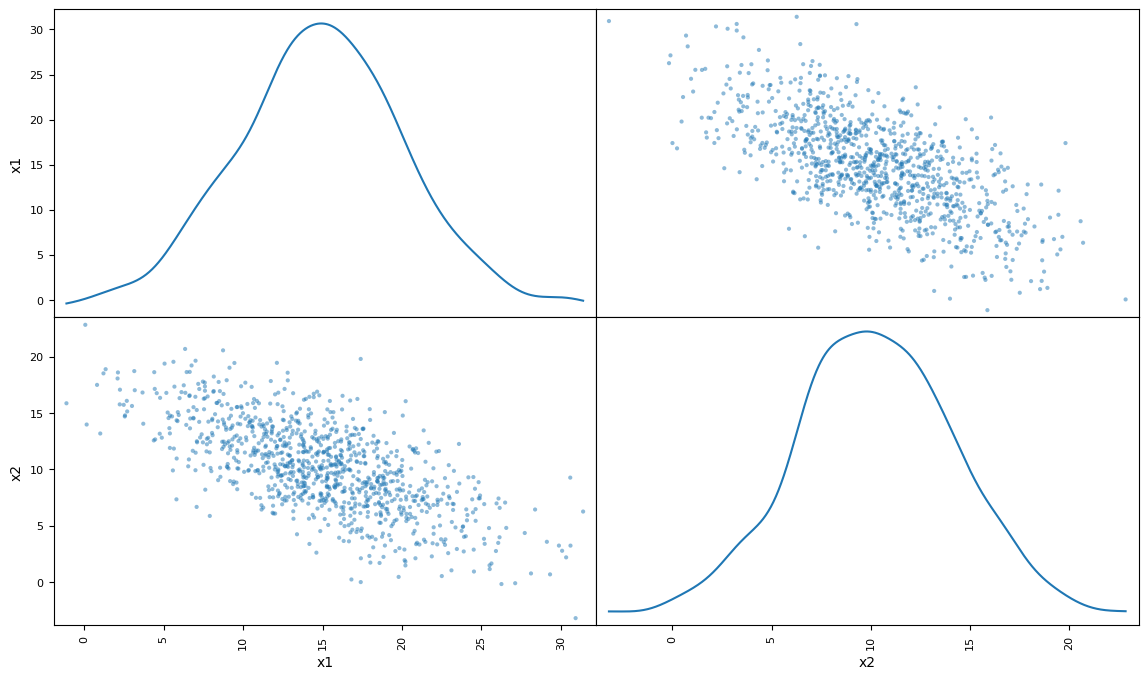

In [114]:
dt_missing_var = gen_data(y_type='multivariate', params=dist_params, seed=RANDOM_SEED)

display(dt_missing_var)

# Посмотрим на корреляции глазами
pd.plotting.scatter_matrix(dt_missing_var[['x1', 'x2']], figsize = (14,8), diagonal = 'kde')

## Построим графики плотностей $x_1$ и $x_2$

d:\Users\nik_p\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


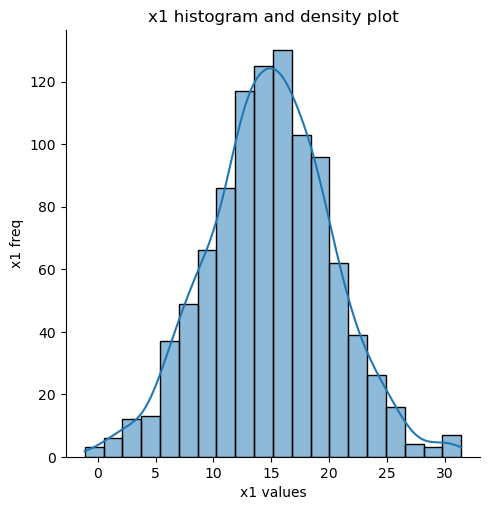

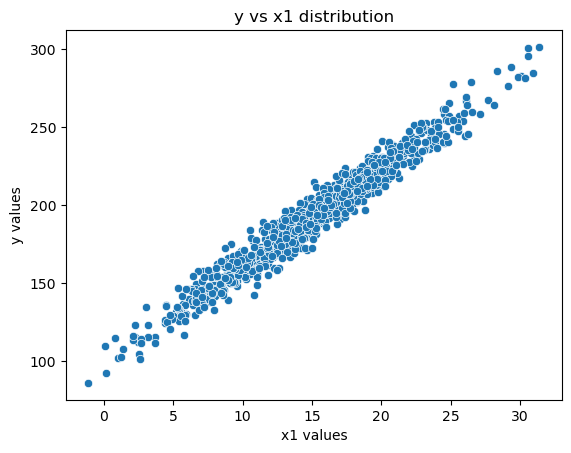

d:\Users\nik_p\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


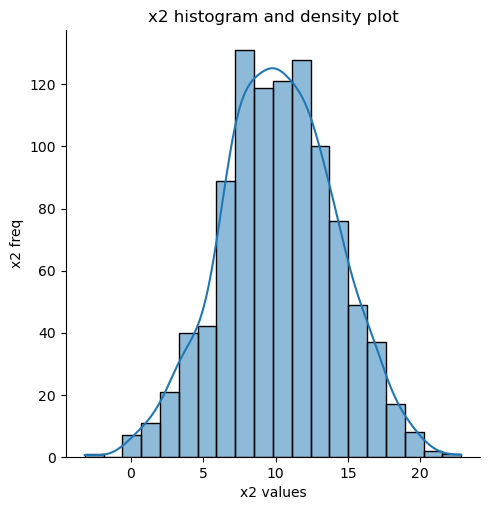

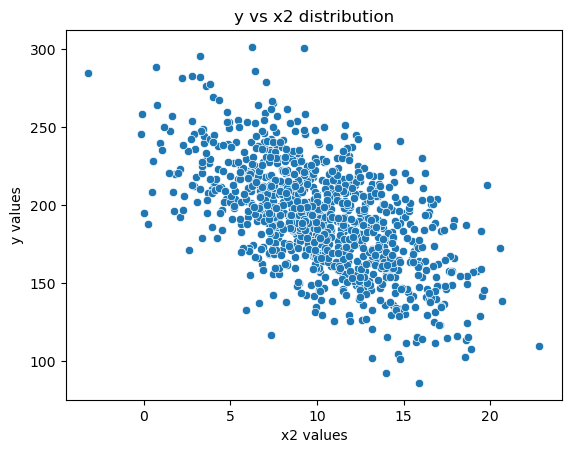

In [115]:
plot_data(dt_missing_var, target='y', feature_names=['x1', 'x2'], plot_type='EDA')

<Axes: xlabel='x1', ylabel='Density'>

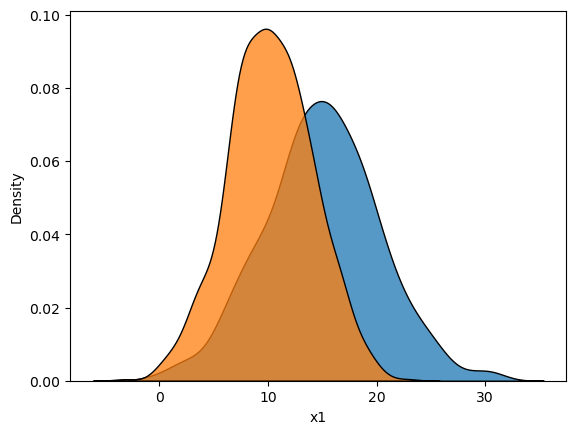

In [116]:
sns.kdeplot(dt_missing_var['x1'], multiple="stack")
sns.kdeplot(dt_missing_var['x2'], multiple="stack")

## Похоже, что  $x_1$ и $x_2$ распределены нормально, но левые хвосты заметно тяжелее.

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.969
Model:                            OLS   Adj. R-squared:                  0.969
Method:                 Least Squares   F-statistic:                 1.558e+04
Date:                Sat, 24 Feb 2024   Prob (F-statistic):               0.00
Time:                        15:11:24   Log-Likelihood:                -3193.0
No. Observations:                1000   AIC:                             6392.
Df Residuals:                     997   BIC:                             6407.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         77.5300      1.268     61.158      0.0

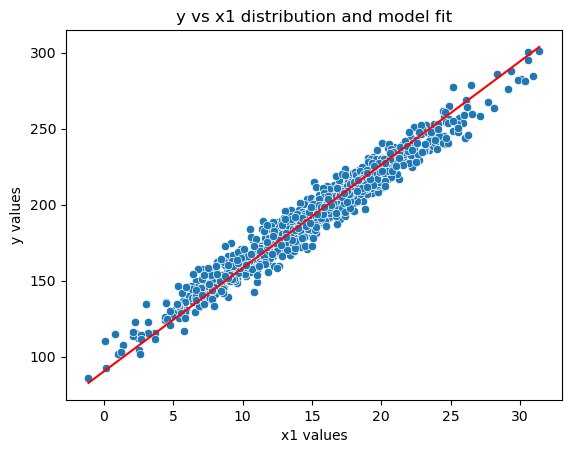

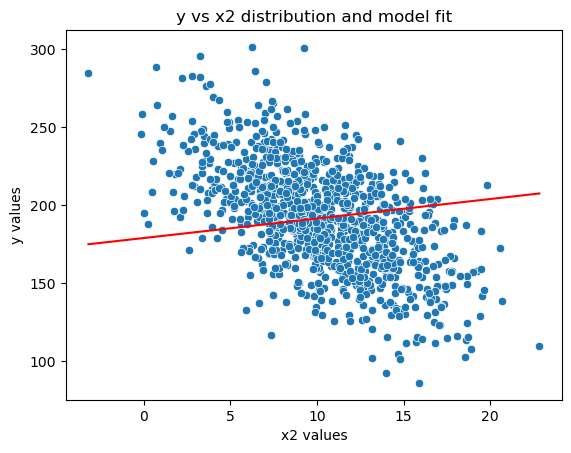

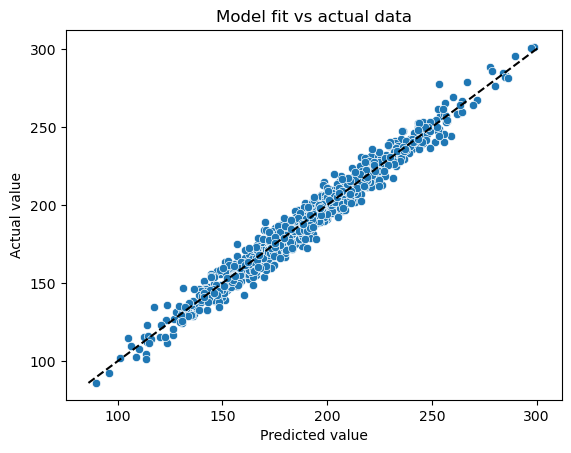

d:\Users\nik_p\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


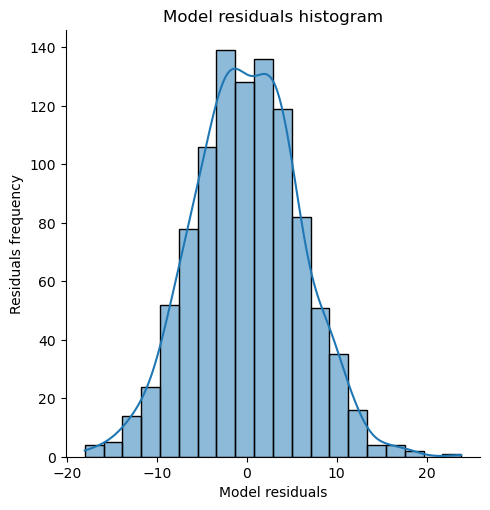

,test,p_level,a_level,a_calc,a_calc >= a_level,statistic,critical_value,statistic < critical_value,conclusion
0,Shapiro-Wilk test,0.95,0.05,0.672752,True,0.998677,,,gaussian distribution
1,Epps-Pulley test,0.95,0.05,0.957763,True,0.014878,0.3778,True,gaussian distribution
2,D'Agostino's K-squared test,0.95,0.05,0.407309,True,1.796368,,,gaussian distribution
3,Anderson-Darling test,0.95,0.05,,,0.225355,0.784,True,gaussian distribution
4,Kolmogorov–Smirnov test,0.95,0.05,0.884376,True,0.018314,,,gaussian distribution
5,Lilliefors test,0.95,0.05,0.641481,True,0.018434,,,gaussian distribution
6,Cramér–von Mises test,0.95,0.05,0.956451,True,0.035144,,,gaussian distribution
7,Chi-squared test,0.95,0.05,0.0,False,140737488355328081920.0,,,not gaussian distribution
8,Jarque–Bera test,0.95,0.05,-,-,-,,,count less than 2000
9,skewtest,0.95,0.05,0.445155,True,0.763517,,,gaussian distribution


In [117]:
dt_missing_var, model_missing_var = train_model(dt_missing_var, target='y', feature_names=['x1', 'x2'], show_results=True, return_norm_tests=True)

## $\bullet$ Как видно из результатов стат. тестов. Остатки имеют нормальное распределение. 

## $\bullet$ Коэффициенты $\beta_1$ и $\beta_2$ попадают в свои доверительные итервалы, значит можно сделать вывод о том, что наша модель корректна.

## 2. Отрисуйте графики:

## $\quad \quad $ $a. \quad    $    $y$ vs $x_1$, $y$ vs $x_2$, $y$ vs $\hat{y}$, распределения остатков модели. Дайте свои комментарии. 

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.969
Model:                            OLS   Adj. R-squared:                  0.969
Method:                 Least Squares   F-statistic:                 1.558e+04
Date:                Sat, 24 Feb 2024   Prob (F-statistic):               0.00
Time:                        15:11:26   Log-Likelihood:                -3193.0
No. Observations:                1000   AIC:                             6392.
Df Residuals:                     997   BIC:                             6407.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         77.5300      1.268     61.158      0.0

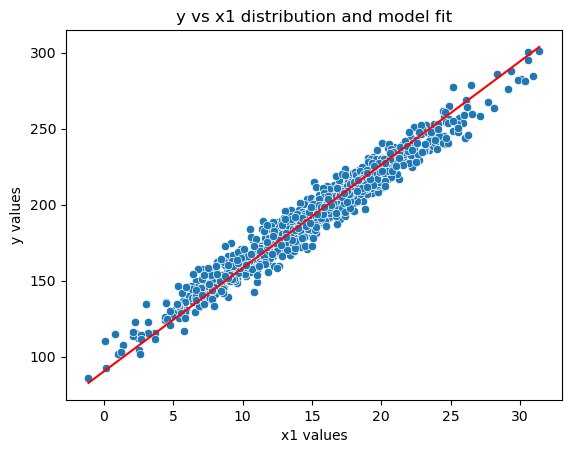

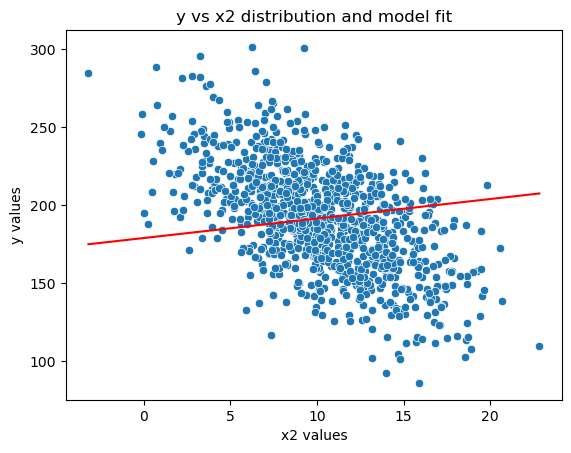

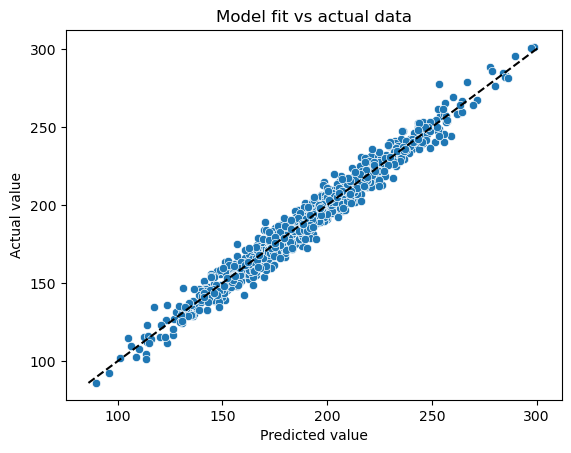

d:\Users\nik_p\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


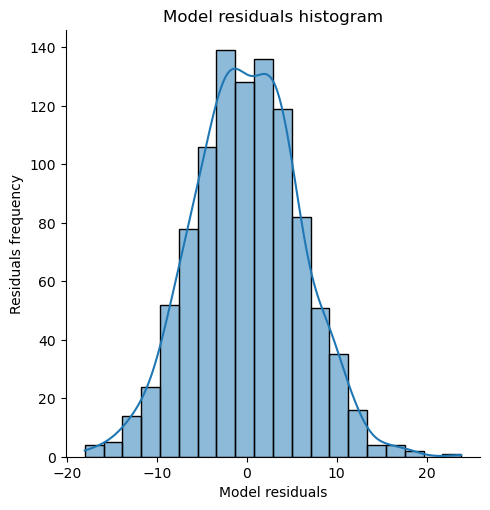

In [118]:
dt_missing_var, model_missing_var = train_model(dt_missing_var, target='y', feature_names=['x1', 'x2'], show_results=True, return_norm_tests=False)


## $\bullet$ Видно, что на графике $y$ vs $x_1$ точки расположены вдоль линии. Можно сделать вывод о том, что $y$ и $x_1$ линейно взаимосвязаны.

## $\bullet $Обратная ситуация на графике $y$ vs $x_1$. Точки не расположены вдоль линии. Значит $y$ и $x_1$ линейно не взаимосвязаны.

## $\bullet$ На графике $y$ vs $\hat{y}$ точки расположены вдоль линии. Делаем вывод о том, что есть высокая корреляция между реальными и предсказанными значениями.


## $\quad \quad $ $b. \quad$ Проведите симуляцию изменения результатов модели в зависимости от размера выборки N = 30 ... 1000, сохравняя оценки и стандартные ошибки коэффициентов $\hat{\beta_1}$ и $\hat{\beta_2}$ от N.

In [119]:
beta_1_sim = []
beta_2_sim = []
std_beta_1_sim = []
std_beta_2_sim = []

for n in range(30, 1001):
    dist_params['N'] = n
    dt_missing_var = gen_data(y_type='multivariate', params=dist_params, seed=RANDOM_SEED)

    # Создадим матрицу фичей как фактор x1 и единичный вектор, на который будет фиттиться константа
    X = sm.add_constant(dt_missing_var[['x1', 'x2']])
    
    # Зафитим модель на данные. y - наша целевая переменная, X - матрица факторов
    model = sm.OLS(dt_missing_var['y'], X).fit()

    beta_1_sim.append(model.params['x1'])
    beta_2_sim.append(model.params['x2'])
    std_beta_1_sim.append(model.bse['x1'])
    std_beta_2_sim.append(model.bse['x2'])


simulation_results = pd.DataFrame({
    'N': range(30, 1001),
    'beta_1': beta_1_sim,
    'beta_2': beta_2_sim,
    'std_errors_beta_1': std_beta_2_sim,
    'std_errors_beta_2': std_beta_2_sim
})

C:\Users\nik_p\AppData\Local\Temp\ipykernel_11912\2240594843.py:2: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,2,1)


Text(0, 0.5, 'beta_2')

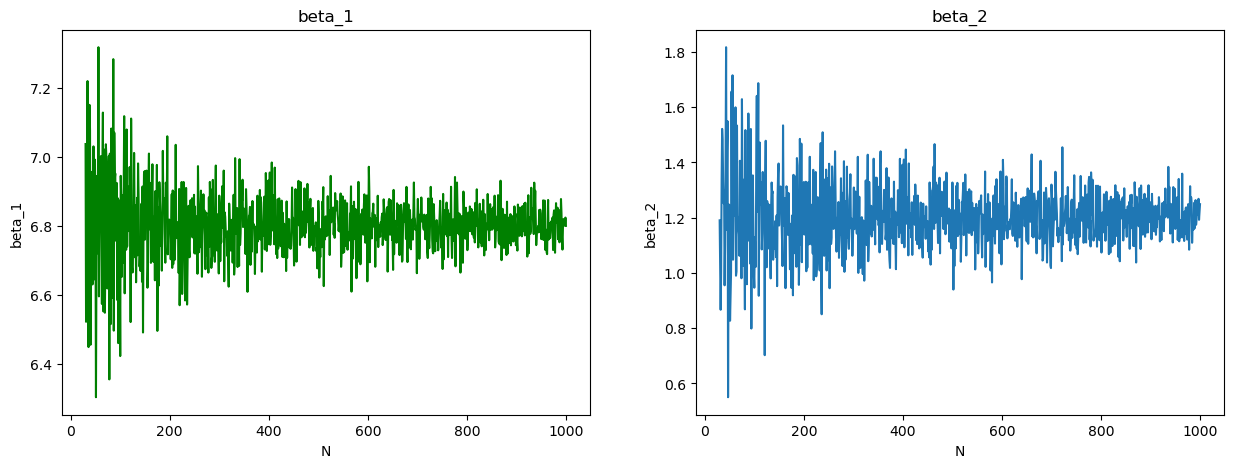

In [120]:
plt.subplots(figsize=(15, 5))
plt.subplot(1,2,1)
plt.plot(simulation_results['N'],  simulation_results['beta_1'], 'g')
plt.title('beta_1')
plt.xlabel('N')
plt.ylabel('beta_1')
plt.subplot(1,2,2)
plt.plot(simulation_results['N'], simulation_results['beta_2'])
plt.title('beta_2')
plt.xlabel('N')
plt.ylabel('beta_2')

C:\Users\nik_p\AppData\Local\Temp\ipykernel_11912\2057764726.py:2: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,2,1)


Text(0, 0.5, 'std_errors_beta_1')

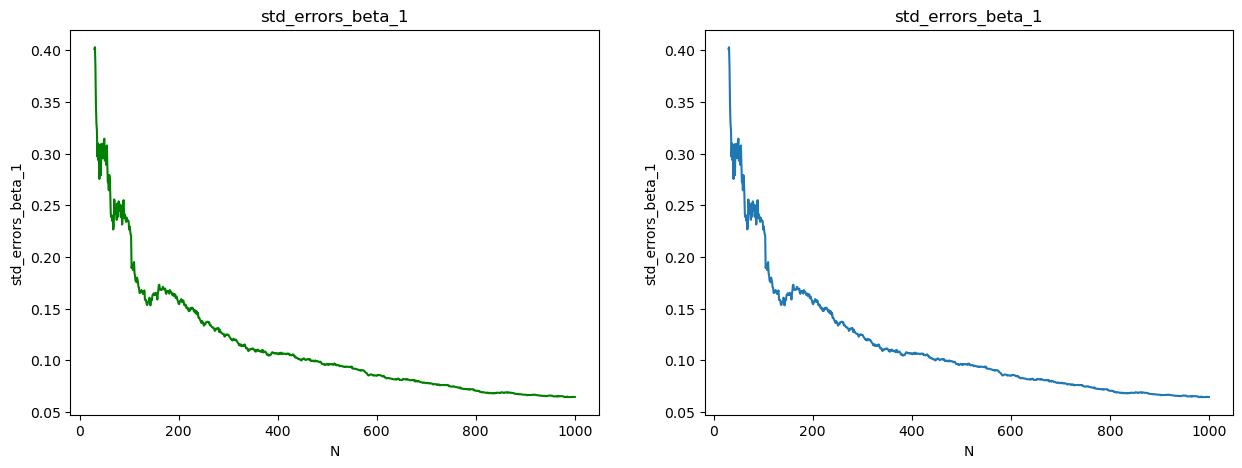

In [121]:
plt.subplots(figsize=(15, 5))
plt.subplot(1,2,1)
plt.plot(simulation_results['N'],  simulation_results['std_errors_beta_1'], 'g')
plt.title('std_errors_beta_1')
plt.xlabel('N')
plt.ylabel('std_errors_beta_1')
plt.subplot(1,2,2)
plt.plot(simulation_results['N'], simulation_results['std_errors_beta_2'])
plt.title('std_errors_beta_1')
plt.xlabel('N')
plt.ylabel('std_errors_beta_1')

## $\quad \quad $ $c. \quad$ Отрисуйте графики зависимости оценок коэффициентов $\hat{\beta_1}$ и $\hat{\beta_2}$ от N. Добавьте на этих графиках верхнюю и нижнюю границу двустороннего доветельного интервала оценок $\hat{\beta_1}$ и $\hat{\beta_2}$ при $\alpha = 5$%. Дайте комментарии по результатам, которые видите на графике.

In [122]:
simulation_results['lower_bound_beta_1'] = sci.stats.t.interval(confidence=0.95, df=len(simulation_results) - 1, loc=np.mean(simulation_results['beta_1']), scale=np.std(simulation_results['beta_1']))[0]
simulation_results['upper_bound_beta_1'] = sci.stats.t.interval(confidence=0.95, df=len(simulation_results) - 1, loc=np.mean(simulation_results['beta_1']), scale=np.std(simulation_results['beta_1']))[1]
simulation_results['lower_bound_beta_2'] = sci.stats.t.interval(confidence=0.95, df=len(simulation_results) - 1, loc=np.mean(simulation_results['beta_2']), scale=np.std(simulation_results['beta_2']))[0]
simulation_results['upper_bound_beta_2'] = sci.stats.t.interval(confidence=0.95, df=len(simulation_results) - 1, loc=np.mean(simulation_results['beta_2']), scale=np.std(simulation_results['beta_2']))[1]

C:\Users\nik_p\AppData\Local\Temp\ipykernel_11912\3802128283.py:2: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,2,1)


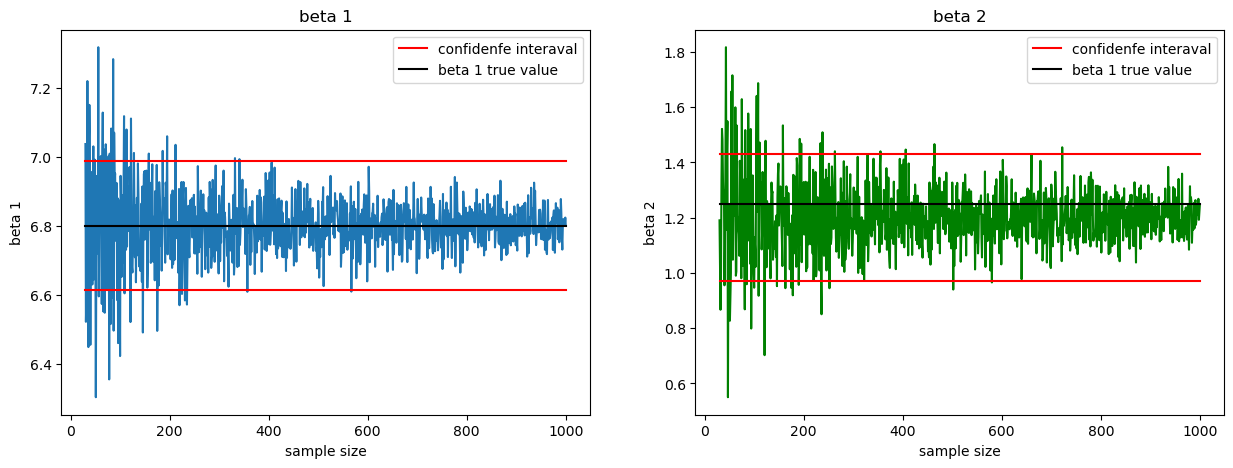

In [167]:
plt.subplots(figsize=(15, 5))
plt.subplot(1,2,1)
plt.plot(simulation_results['N'],  simulation_results['beta_1'])
plt.plot(simulation_results['N'],  simulation_results['lower_bound_beta_1'], 'r')
plt.plot(simulation_results['N'],  simulation_results['upper_bound_beta_1'], 'r', label='confidenfe interaval')
plt.plot(simulation_results['N'],  np.repeat(model_missing_var.params['x1'], 971), 'k', label='beta 1 true value')
plt.title('beta 1')
plt.xlabel('sample size')
plt.ylabel('beta 1')
plt.legend()
plt.subplot(1,2,2)
plt.plot(simulation_results['N'],  simulation_results['beta_2'], 'g')
plt.plot(simulation_results['N'],  simulation_results['lower_bound_beta_2'], 'r')
plt.plot(simulation_results['N'],  simulation_results['upper_bound_beta_2'], 'r', label='confidenfe interaval')
plt.plot(simulation_results['N'],  np.repeat(model_missing_var.params['x2'], 971), 'k', label='beta 1 true value')
plt.title('beta 2')
plt.xlabel('sample size')
plt.ylabel('beta 2')
plt.legend()

## $\bullet$По графикам видно, что с увеличением размера выборки $\hat{\beta_1}$ и $\hat{\beta_2}$ стремятся к своим истинным значениям.

 ## $\bullet$Также $\hat{\beta_1}$ и $\hat{\beta_2}$ попадают в свои доверительные интервалы.